In [3]:
import pandas as pd
import numpy as np

In [4]:
df_model1_0220 = pd.read_csv('model1_0220.csv',encoding='gbk')
df_model1_0310 = pd.read_csv('model1_0310.csv',encoding='gbk')
df_model1_0401 = pd.read_csv('model1_0401.csv',encoding='gbk')
df_model1_0420 = pd.read_csv('model1_0420.csv',encoding='gbk')

In [5]:
df = pd.concat([df_model1_0220,df_model1_0310,df_model1_0401,df_model1_0420],axis=0,ignore_index=True)

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 20 11:19:45 2017

@author: zhangzerong
"""

# 自动化分箱工具
# 根据train的分箱方法，自动替换到总数据集上
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
from scipy.stats import spearmanr

def woe_function(df,df_t,column,woe_type='d',q=5,method='spearmanr',corr=0.95,add_woe=False,woe_sort=False,add_total_woe=True):
    '''
    df 要被处理的数据集
    df_t 总数据集
    column 要被处理的列名
    dtype = 'd' 离散，默认为离散 ;dtype = 'c' 连续
    q = 5 针对连续型和离散型变量的设定不一样。
          针对连续型变量：1）默认连续型变量取值将分为5段，如果需要修改最终分段数，则传入一个数字；
                         2）如果需要按照既定的规则分段，则传入一个列表(注意列表格式，要分成3段，只需要传入两个参数即可，不需要上下界)
          针对离散型变量：1）默认按照离散变量的原始标签类进行分段
                         2）如果需要按照既定的规则分段，则传入一个字典（字典key为原始标签，value为既定规则后的分类）         
    method = 连续型变量分箱收敛方法
            'spearmanr'为斯皮尔曼相关系数，默认为'spearmanr'方法；
            'chi-square'为计算相邻两组卡方值，每次循环合并卡方值最小的两组；
            'minus'为计算相邻两组woe，每次循环合并woe差最小的两组
    add_woe = False 表示是否将woe编码后的列加入到df中，默认False
    woe_sort = False 表示是否将df_woe按照woe的值从小到大排列index，主要针对离散变量
    '''
    if woe_type == 'd':
        df_woe,column_iv = d_plot(df,df_t,column,q,woe_sort)
    elif woe_type == 'c':
        df_woe,column_iv = c_plot(df,df_t,column,q,method,corr) 
    if add_woe:
        woe_dict = dict(zip(df_woe.index,df_woe['woe']))
        df[column+'_woe'] = df[column+'_fillna'].map(woe_dict)
    if add_total_woe:
        woe_dict = dict(zip(df_woe.index,df_woe['woe']))
        df_t[column+'_woe'] = df_t[column+'_fillna'].map(woe_dict)
    df.drop([column+'_fillna'],axis=1,inplace=True)
    df_t.drop([column+'_fillna'],axis=1,inplace=True)
    woe_plot(df_woe,column_iv)
    return df_woe
    
def d_plot(df,df_t,column,q,woe_sort):
    '''
    如果需要对离散型变量的分类做处理，则传入一个字典DC；不传则默认按照原始的分类来处理
    '''
    df[column+'_fillna'] = df[column].fillna('missing_value')  
    df_t[column+'_fillna'] = df_t[column].fillna('missing_value')       
    if type(q) == dict:
        q['missing_value']='missing_value'
        df[column+'_fillna'] = df[column+'_fillna'].map(q)
        df[column+'_fillna'].fillna('others',inplace=True)
        df_t[column+'_fillna'] = df_t[column+'_fillna'].map(q)
        df_t[column+'_fillna'].fillna('others',inplace=True)
        df_woe,column_iv = cal_iv(df,column+'_fillna')
    else:
        df_woe,column_iv = cal_iv(df,column+'_fillna')
    
    if woe_sort:
        '''这里将无序离散变量，按照woe排序'''
        df_woe = df_woe.sort_values('woe')
    return df_woe,column_iv

def c_plot(df,df_t,column,q,method,corr):
    if type(q) != list:
        if method == 'spearmanr':
            q = spearmanr_q(df,column,corr)
        elif method == 'chi-square':
            q = chi_square_q(df,column)
        elif method == 'minus':
            q = chi_square_q(df,column)
    q.insert(0,-np.inf)
    q.append(np.inf)
    df[column+'_fillna'] = pd.cut(df[column],q)
    df_t[column+'_fillna'] = pd.cut(df_t[column],q)
    df[column+'_fillna'] = df[column+'_fillna'].astype(object).fillna('missing_value')
    df_t[column+'_fillna'] = df_t[column+'_fillna'].astype(object).fillna('missing_value')
    df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
    return df_woe,column_iv

def spearmanr_q(df,column,corr):
    '''
    spearmanr分箱方法
    原理：
        初始用qcut方法分成n段，实际有可能出现少于n段的情况（例如某一段占比大于1/n)
        按照这样的分段计算出df_woe，判断woe的spearman相关系数是否大于corr，如果大于，则停止循环，否则n减少1
        最终必然收敛（在分成两段的时候）
    '''
    r = 0
    n = 15
    while np.abs(r) < corr:
        df[column+'_fillna'],q = pd.qcut(df[column],n,retbins=True,duplicates='drop')
        df[column+'_fillna'] = df[column+'_fillna'].astype(object)
        df[column+'_fillna'] = df[column+'_fillna'].fillna('missing_value')
        df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
        if 'missing_value' in df_woe:    
            df_woe.drop('missing_value',inplace=True)
        r = spearmanr(range(len(df_woe)),df_woe['woe']).correlation
        q = q.tolist()
        n -= 1
    return q
        
def chi_square_q(df,column):
    '''通过chi_square来确定最优的分箱'''
    n_begin = 50
    df[column+'_fillna'],q = pd.qcut(df[column],n_begin,retbins=True,duplicates='drop')
    df[column+'_fillna'] = df[column+'_fillna'].astype(object).fillna('missing_value')
    df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
    if 'missing_value' in df_woe:
        df_woe.drop('missing_value',inplace=True)
    q = q.tolist()
    q.pop(0)
    q.pop()
    i = len(q)+1
    while i>5:
        q.insert(0,-np.inf)
        q.append(np.inf)
        df[column+'_fillna'] = pd.cut(df[column],q)
        df[column+'_fillna'] = df[column+'_fillna'].astype(object).fillna('missing_value')
        df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
        if 'missing_value' in df_woe:
            df_woe.drop('missing_value',inplace=True)
        temp={}
        for i in range(len(df_woe)-1):
            a=df_woe.iloc[i]['bad_count']
            b=df_woe.iloc[i]['good_count']
            c=df_woe.iloc[i+1]['bad_count']
            d=df_woe.iloc[i+1]['good_count']
            temp[i] = (a+b+c+d)*(a*d-b*c)**2/((a+b)*(c+d)*(a+c)*(b+d))
        q.pop(min(temp, key=temp.get)+1) #合并卡方值最小的那一个分类
        q.pop(0)
        q.pop()
        i=len(q)+1
    return q       

def minus_q(df,column):
    '''通过相邻的woe两两比较大小来确定最优的分箱'''
    n_begin = 50
    df[column+'_fillna'],q = pd.qcut(df[column],n,retbins=True,duplicates='drop')
    df[column+'_fillna'] = df[column+'_fillna'].astype(object).fillna('missing_value')
    df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
    if 'missing_value' in df_woe:
        df_woe.drop('missing_value',inplace=True)
    q = q.tolist()
    q.pop(0)
    q.pop()
    i = len(q)+1
    while i>5:
        q.insert(0,-np.inf)
        q.append(np.inf)
        df[column+'_fillna'] = pd.cut(df[column],q)
        df[column+'_fillna'] = df[column+'_fillna'].astype(object).fillna('missing_value')
        df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
        if 'missing_value' in df_woe:
            df_woe.drop('missing_value',inplace=True)
        temp={}
        for i in range(len(df_woe)-1):
            temp[i]=abs(df_woe.iloc[i]['woe']-df_woe.iloc[i+1]['woe'])
        q.pop(min(temp, key=temp.get)+1) #合并woe差值最小的那一个分类
        q.pop(0)
        q.pop()
        i=len(q)+1
    return q
    

def cal_iv(df,column,index_sort=False):
    df_bad = df[df['y2']==1].groupby(df[column]).size().to_frame(name='bad_count')
    df_good = df[df['y2']==0].groupby(df[column]).size().to_frame(name='good_count')
    df_woe = pd.merge(df_bad,df_good,how='outer',left_index=True,right_index=True)
    df_woe.fillna(0.001,inplace=True) #为了保证不出现空值
    df_woe['n_group']=df_woe['bad_count']+df_woe['good_count']
    df_woe['bad_rate']=df_woe['bad_count']/df_woe['n_group']
    df_woe['bad_ratio'] = df_woe['bad_count']/sum(df_woe['bad_count'])
    df_woe['good_ratio'] = df_woe['good_count']/sum(df_woe['good_count'])
    df_woe['woe'] = np.log(df_woe['bad_ratio']/df_woe['good_ratio'])
    df_woe['iv'] = (df_woe['bad_ratio']-df_woe['good_ratio'])*df_woe['woe']
    '''分组后可能出现分段不排序的问题，这里将“连续变量”的分段，做一个排序'''
    if index_sort:
        index_list=df_woe.index.tolist()
        if 'missing_value' in index_list:
            index_list.remove('missing_value')
            index_list.sort()
            index_list.append('missing_value')
        else:
            index_list.sort()
        df_woe = df_woe.reindex(index_list)
    column_iv = sum(df_woe['iv'])
    df_woe.drop(['bad_ratio','good_ratio'],axis=1,inplace=True)
    return df_woe,column_iv

'''以下要重新自己写一遍,图形太难看'''
def woe_plot(df_woe,column_iv):
    matplotlib.rcParams.update({'font.size': 12})
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False
    fig,ax1 = plt.subplots()
    ax=ax1.twinx()
    ax1.bar(range(len(df_woe)),df_woe.n_group,color='cadetblue')
    ax1.set_ylabel('group number',fontsize=11)
    fig.set_size_inches(10,4)
    ax.plot(range(len(df_woe)),df_woe.woe,marker='d',color='darkslateblue')
    plt.annotate('IV=%s' % "{:2.3f}".format(column_iv), xy=(0.05, 0.90), xycoords='axes fraction',fontsize=12)
    lables=[i for i in df_woe.index]
    pl.xticks(range(len(df_woe)),lables)#,rotation=)
    ax.set_ylabel('woe')
    #ax.grid(b=True)
    ax.set_title('groupy number——woe')
    plt.show()
"""
Created on Thu Sep 28 10:38:02 2017

@author: zhangzerong
"""

#模型结果及评价
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
def credit_card(df,columns,y):
    '''
    df : 要被处理的dataframe
    columns  : 已经woe转换过的列（对应woe_fuction）
    y : 标签列
    '''
    x_train,x_test,y_train,y_test = train_test_split(df[columns],df[y],test_size = 0.3,random_state = 99)
    clf = LogisticRegression()
    clf.fit(x_train,y_train)
    '''输出模型结果'''
    print_log(columns,clf.coef_[0],clf
              .intercept_[0])
    
    train_log_odds = x_train[columns].dot(clf.coef_[0]) + clf.intercept_[0]
    test_log_odds = x_test[columns].dot(clf.coef_[0]) + clf.intercept_[0]    
    train_prob = 1.0/(1+np.exp(-train_log_odds))
    test_prob = 1.0/(1+np.exp(-test_log_odds))
    '''计算分值并打印结果'''
#    normal_odds = len(df[df[y]==1])/len(df[df[y]==0])#初始的坏客户/好客户比率
    normal_odds = 1/20
    A,B = get_score(normal_odds)
    train_score = A + B * train_log_odds
    test_score = A + B * test_log_odds
    print('the score is given by : score = %s %s * ln(odds)' % (A,B))
    print('tips : odds = p/(1-p)')
    print('\n'+'  =￣ω￣=  ' * 10+'\n')
    '''输出ks值'''
    fig,ax=plt.subplots()
    aa=ks_chart(ax,train_score,y_train,'Train',style='-',set_ax=True)
    bb=ks_chart(ax,test_score,y_test,'Test',style='--',set_ax=False)
    ax.legend(aa[0]+bb[0],aa[1]+bb[1],loc='upper left')
    '''输出ROC曲线（附带AUC\GINI）'''
    ROC_curve([(y_train,train_prob,'train'),(y_test,test_prob,'test')]) 
    return clf.intercept_[0],clf.coef_[0],A,B
    
def print_log(columns,coef,intercept):
    print ('the logistic regression result is :')
    print ('ln[p/(1-p)] = %s' % intercept)
    for i in range(len(columns)):
        if coef[i]>=0:
            sign = '+'
        else:
            sign = ''
        print(' '* 14 + sign + '%s * %s' % (coef[i],columns[i]))

def ROC_curve(params):
    fig,ax=plt.subplots()
    text = ''
    for param in params:
        label,prob,name = param
        fpr,tpr,_ = metrics.roc_curve(label,prob)
        ax.plot(fpr,tpr,'-',label=name)
        AUC = metrics.auc(fpr,tpr)
        GINI = 2 * AUC - 1
        text = text + '%s AUC:  %s\n' % (name,"{:10.3f}".format(AUC))
        text = text + '%s GINI: %s\n' % (name,"{:10.3f}".format(GINI))
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('ROC Curve',fontsize=13)
    ax.legend(loc='center right')
    ax.text(0.6,-0.1,text)
    plt.show()

def get_score(normal_odds,base_score=500,pdo=100):
    '''
    基础分为500分，每降低100分，odds翻倍；分值越大说明用户越好（为了便于理解）
    '''
    b = - pdo / np.log(2)
    a = base_score - b*np.log(normal_odds)
    return a,b

def percentile(a,scores):
    percentiles=[]
    for s in scores:
        percentiles.append(stats.percentileofscore(a,s))
    return np.array(percentiles)

def ks_chart(ax,score,y,label, style='-', print_ks=False,set_ax=True):
    '''
    ax:    Matplotlib Axes
    score: score array (np array or pandas column)
    y:     good / bad lables
    print_ks: need print KS value on the plot or not
    set_ax : need make some setting for the plot or not
    '''
    ax1 = ax.twinx()
    bins = np.linspace(score.min(),score.max(),200)
    groups=score.groupby(y)
    cumlative_per=[]
    axes=[]
    labels=[]
    for group,data in groups:
        q=percentile(data,bins)
        cumlative_per.append(q)
        lab = '%s (%s)' % ("{:1.0f}".format(group),label)
        labels.append(lab)
        a=ax1.plot(bins,q,style,label=lab,lw=1.5)
        if isinstance(a,list):
            axes.append(a[0])
        else:
            axes.append(a)
    ks_values=cumlative_per[1]-cumlative_per[0]
    if len(ks_values[ks_values<0])>0.9*len(bins):
        ks_values = -ks_values
    max_ks=np.max(ks_values)
    lab='KS (%s)' % label
    labels.append(lab)
    a=ax.plot(bins,ks_values,style,label=lab,lw=0.5)
    if isinstance(a,list):
        axes.append(a[0])
    else:
        axes.append(a)
    ax.grid(b=True,linestyle='--')
    if print_ks:
        ax.text(0.8, 0.97,'Max K-S:%s' % "{:10.2f}".format(max_ks),  horizontalalignment='center',  verticalalignment='center', transform = ax.transAxes,fontsize=11)
    if set_ax:
        ax.set_title('KS plot',fontsize=13)
        ax.set_xlabel('score')
        ax.set_ylabel('K-S Value')
        ax1.set_ylabel('Cumulative percentage')
    print ('the ks of %s is %s' % (label,"{:1.2f}".format(max_ks)))
    return  axes,labels
from sklearn.model_selection import train_test_split

In [7]:
#train,test
df_train,df_test = train_test_split(df,test_size = 0.3,random_state = 99)
df_train = df_train.sort_index(ascending=True)
df_test = df_test.sort_index(ascending=True)

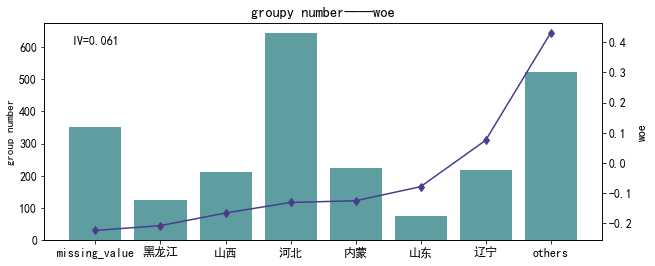

In [8]:
province = woe_function(df_train,df,'province',q={13:'河北',14:'山西',15:'内蒙',21:'辽宁',23:'黑龙江',37:'山东'},woe_sort=True)

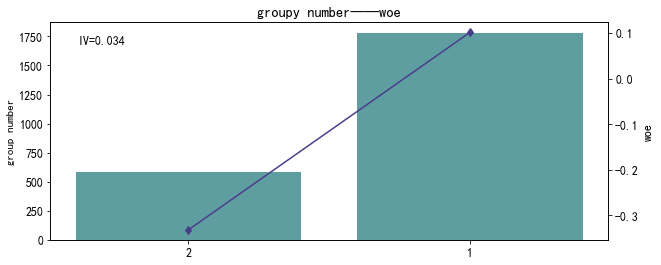

In [9]:
nsex = woe_function(df_train,df,'nsex',woe_sort=True)

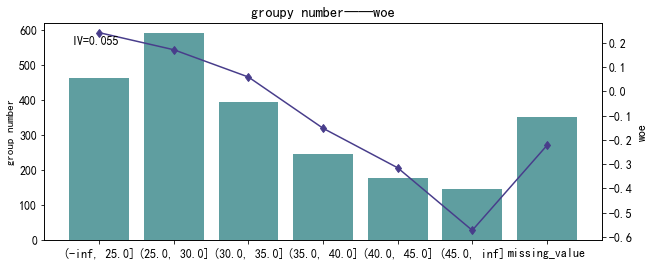

In [10]:
age = woe_function(df_train,df,'age',woe_type='c',q=[25,30,35,40,45])

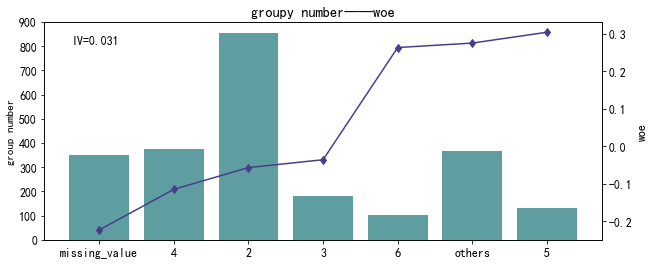

In [11]:
company_duty_name = woe_function(df_train,df,'company_duty_name',q={ '销售/中介/业务代表/促销':2,
       '个体':2,
       '司机':2,
       '商业、服务业人员':2,
       '高层管理人员/总监以上/局级以上干部':3,
       '基层管理人员/主管组长/科员':4,
       '中层管理人员.经理以上/科级以上干部':4,
       '专业（技术）人员':5,
       '工人(包括生产、加工、建筑和设备操作人员及有关人员)':6,
       '农民':6,
       '保安/治安/防损':6
},woe_sort=True)

d:\users\zhangzerong\appdata\local\programs\python\python36\lib\site-packages\pandas\core\reshape\merge.py:722: RuntimeWarning: unorderable types: Interval() < str(), sort order is undefined for incomparable objects
  sort=self.sort)


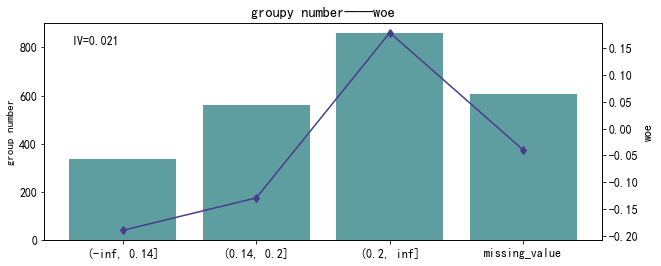

In [12]:
credit_dept_overdue_ratio = woe_function(df_train,df,'credit_dept_overdue_ratio',q=[0.14,0.2],woe_type='c')

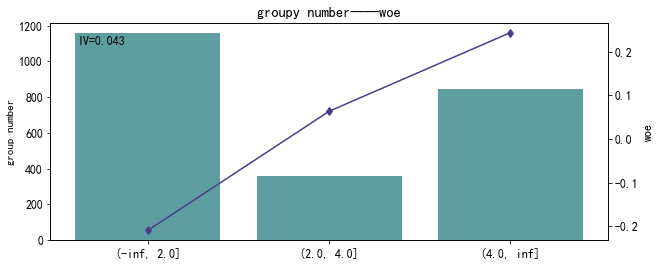

In [13]:
observation_overdue10day_times = woe_function(df_train,df,'observation_overdue10day_times',q=[2,4],woe_type='c')

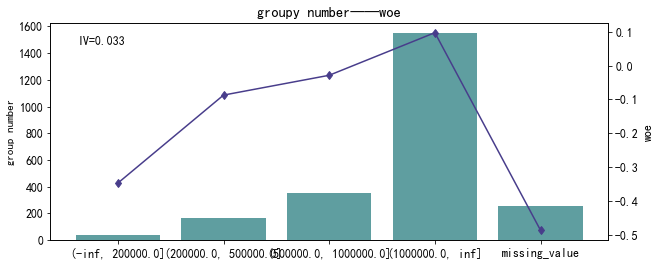

In [14]:
observation_overdue5day_amount = woe_function(df_train,df,'observation_overdue5day_amount',q=[200000,500000,1000000],woe_type='c')

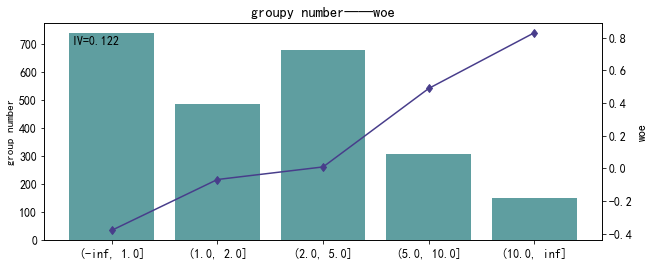

In [15]:
onway_loan_times = woe_function(df_train,df,'onway_loan_times',q=[1,2,5,10],woe_type='c')

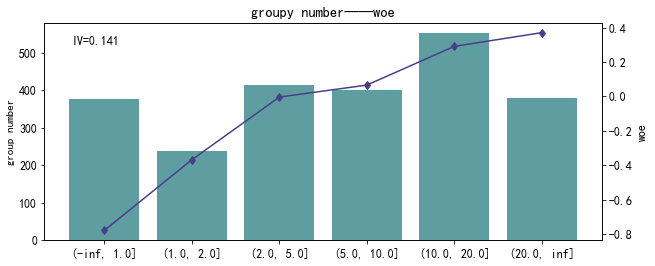

In [16]:
onway_overdue_days_max = woe_function(df_train,df,'onway_overdue_days_max',q=[1,2,5,10,20],woe_type='c')

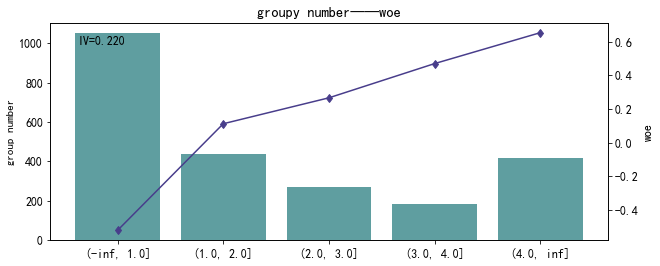

In [17]:
onway_overdue_terms = woe_function(df_train,df,'onway_overdue_terms',woe_type='c',q=[1,2,3,4])

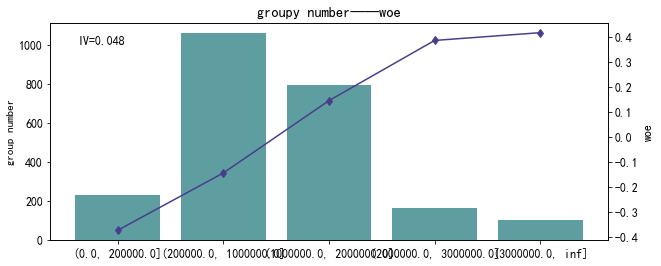

In [18]:
overdue_amount_last_6months = woe_function(df_train,df,'overdue_amount_last_6months',q=[0,200000,1000000,2000000,3000000],woe_type='c')

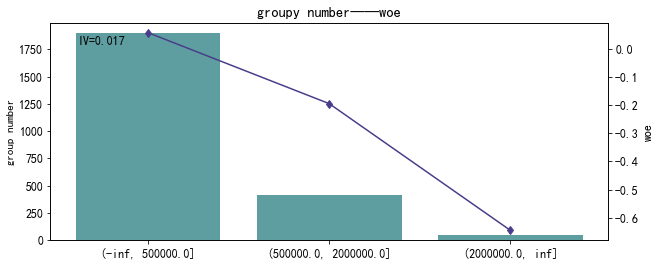

In [19]:
prepay_amount_last_3months = woe_function(df_train,df,'prepay_amount_last_3months',q=[500000,2000000],woe_type='c')

In [20]:
columns = ['age_woe',
                'company_duty_name_woe',
              'credit_dept_overdue_ratio_woe',
              'nsex_woe',
              'observation_overdue10day_times_woe',
               'observation_overdue5day_amount_woe',
              'onway_loan_times_woe',
              'onway_overdue_days_max_woe',
               'onway_overdue_terms_woe',
              'overdue_amount_last_6months_woe',
              'prepay_amount_last_3months_woe',
              'province_woe']

the logistic regression result is :
ln[p/(1-p)] = -0.530223678505
              +0.567392315359 * age_woe
              +0.641343293149 * company_duty_name_woe
              +0.600090025211 * credit_dept_overdue_ratio_woe
              +0.745281640602 * nsex_woe
              +0.334052316522 * observation_overdue10day_times_woe
              +0.172518682777 * observation_overdue5day_amount_woe
              +0.896054775012 * onway_loan_times_woe
              +0.628134048406 * onway_overdue_days_max_woe
              +0.552514029491 * onway_overdue_terms_woe
              +0.987421410682 * overdue_amount_last_6months_woe
              +0.893973468006 * prepay_amount_last_3months_woe
              +0.906364083993 * province_woe
the score is given by : score = 67.8071905113 -144.269504089 * ln(odds)
tips : odds = p/(1-p)

  =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=  

the ks of Train is 30.62
the ks of Test is 29.82


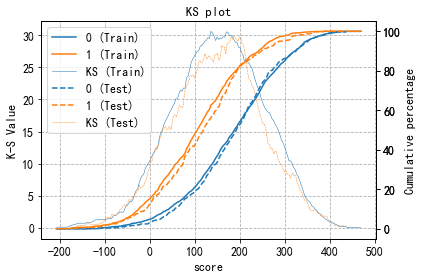

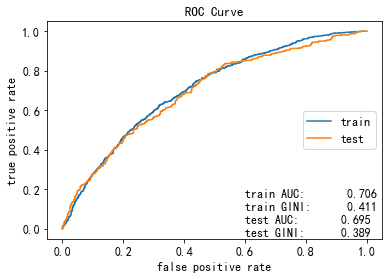

(-0.53022367850480689,
 array([ 0.56739232,  0.64134329,  0.60009003,  0.74528164,  0.33405232,
         0.17251868,  0.89605478,  0.62813405,  0.55251403,  0.98742141,
         0.89397347,  0.90636408]),
 67.807190511263741,
 -144.26950408889635)

In [21]:
credit_card(df,columns,'y2')

the logistic regression result is :
ln[p/(1-p)] = -0.530223678505
              +0.567392315359 * age_woe
              +0.641343293149 * company_duty_name_woe
              +0.600090025211 * credit_dept_overdue_ratio_woe
              +0.745281640602 * nsex_woe
              +0.334052316522 * observation_overdue10day_times_woe
              +0.172518682777 * observation_overdue5day_amount_woe
              +0.896054775012 * onway_loan_times_woe
              +0.628134048406 * onway_overdue_days_max_woe
              +0.552514029491 * onway_overdue_terms_woe
              +0.987421410682 * overdue_amount_last_6months_woe
              +0.893973468006 * prepay_amount_last_3months_woe
              +0.906364083993 * province_woe
the score is given by : score = 67.8071905113 -144.269504089 * ln(odds)
tips : odds = p/(1-p)

  =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=  

the ks of Train is 30.62
the ks of Test is 29.82


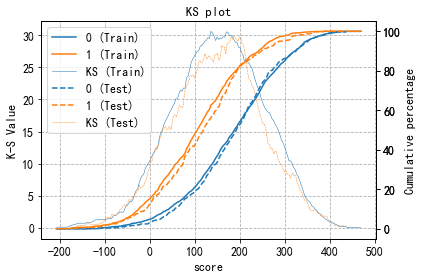

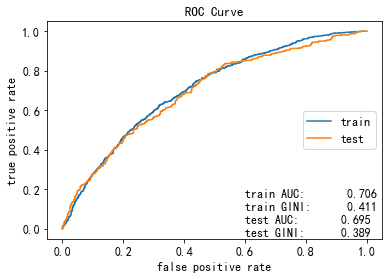

In [22]:
intercpt,coe,a,b = credit_card(df,columns,'y2')

In [23]:
columns

['age_woe',
 'company_duty_name_woe',
 'credit_dept_overdue_ratio_woe',
 'nsex_woe',
 'observation_overdue10day_times_woe',
 'observation_overdue5day_amount_woe',
 'onway_loan_times_woe',
 'onway_overdue_days_max_woe',
 'onway_overdue_terms_woe',
 'overdue_amount_last_6months_woe',
 'prepay_amount_last_3months_woe',
 'province_woe']

In [24]:
age['score'] = age['woe'] * b * coe[0]
company_duty_name['score'] = company_duty_name['woe'] * b * coe[1]
credit_dept_overdue_ratio['score'] = credit_dept_overdue_ratio['woe'] * b * coe[2]
nsex['score'] = nsex['woe'] * b * coe[3]
observation_overdue10day_times['score'] = observation_overdue10day_times['woe'] * b * coe[4]
observation_overdue5day_amount['score'] = observation_overdue5day_amount['woe'] * b * coe[5]
onway_loan_times['score'] = onway_loan_times['woe'] * b * coe[6]
onway_overdue_days_max['score'] = onway_overdue_days_max['woe'] * b * coe[7]
onway_overdue_terms['score'] = onway_overdue_terms['woe'] * b * coe[8]
overdue_amount_last_6months['score'] = overdue_amount_last_6months['woe'] * b * coe[9]
prepay_amount_last_3months['score'] = prepay_amount_last_3months['woe'] * b * coe[10]
province['score'] = province['woe'] * b * coe[11]

In [25]:
age

,bad_count,good_count,n_group,bad_rate,woe,iv,score
age_fillna,,,,,,,
"(-inf, 25.0]",197,264,461,0.427332,0.241850,0.011724,-19.797252
"(25.0, 30.0]",242,348,590,0.410169,0.171331,0.007478,-14.024719
"(30.0, 35.0]",151,243,394,0.383249,0.058814,0.000581,-4.814381
"(35.0, 40.0]",82,163,245,0.334694,-0.152435,0.002358,12.477943
"(40.0, 45.0]",53,124,177,0.299435,-0.315394,0.007100,25.817320
"(45.0, inf]",36,109,145,0.248276,-0.573233,0.018296,46.923376
missing_value,112,239,351,0.319088,-0.223369,0.007172,18.284394


In [26]:
company_duty_name

,bad_count,good_count,n_group,bad_rate,woe,iv,score
company_duty_name_fillna,,,,,,,
missing_value,112,239,351,0.319088,-0.223369,0.007172,20.667487
4,129,247,376,0.343085,-0.114980,0.002070,10.638680
2,305,551,856,0.356308,-0.056827,0.001161,5.258008
3,65,115,180,0.361111,-0.035949,0.000098,3.326229
6,45,59,104,0.432692,0.263721,0.003151,-24.401113
others,159,206,365,0.435616,0.275624,0.012093,-25.502452
5,58,73,131,0.442748,0.304579,0.005313,-28.181600


In [27]:
credit_dept_overdue_ratio

,bad_count,good_count,n_group,bad_rate,woe,iv,score
credit_dept_overdue_ratio_fillna,,,,,,,
"(-inf, 0.14]",110,227,337,0.326409,-0.189874,0.005003,16.438266
"(0.14, 0.2]",190,369,559,0.339893,-0.129177,0.003877,11.183435
"(0.2, inf]",354,505,859,0.412107,0.179334,0.011939,-15.525814
missing_value,219,389,608,0.360197,-0.039912,0.000408,3.455349


In [28]:
nsex

,bad_count,good_count,n_group,bad_rate,woe,iv,score
nsex_fillna,,,,,,,
2,172,409,581,0.296041,-0.331625,0.025693,35.656771
1,701,1081,1782,0.393378,0.101462,0.007861,-10.909328


In [29]:
observation_overdue10day_times

,bad_count,good_count,n_group,bad_rate,woe,iv,score
observation_overdue10day_times_fillna,,,,,,,
"(-inf, 2.0]",373,785,1158,0.322107,-0.209509,0.020864,10.097007
"(2.0, 4.0]",138,221,359,0.384401,0.063687,0.000621,-3.069295
"(4.0, inf]",362,484,846,0.427896,0.244155,0.021932,-11.766706


In [30]:
observation_overdue5day_amount

,bad_count,good_count,n_group,bad_rate,woe,iv,score
observation_overdue5day_amount_fillna,,,,,,,
"(-inf, 200000.0]",12,29,41,0.292683,-0.347793,0.001988,8.656293
"(200000.0, 500000.0]",58,108,166,0.349398,-0.087092,0.000527,2.167658
"(500000.0, 1000000.0]",127,223,350,0.362857,-0.028389,0.000119,0.706575
"(1000000.0, inf]",608,941,1549,0.392511,0.097828,0.006350,-2.434849
missing_value,68,189,257,0.264591,-0.487643,0.023872,12.137048


In [31]:
onway_loan_times

,bad_count,good_count,n_group,bad_rate,woe,iv,score
onway_loan_times_fillna,,,,,,,
"(-inf, 1.0]",212,528,740,0.286486,-0.377914,0.042146,48.854241
"(1.0, 2.0]",172,314,486,0.353909,-0.067303,0.000923,8.700443
"(2.0, 5.0]",252,426,678,0.371681,0.009586,0.000026,-1.239161
"(5.0, 10.0]",151,158,309,0.488673,0.489281,0.032746,-63.250962
"(10.0, inf]",86,64,150,0.573333,0.830060,0.046116,-107.304667


In [32]:
onway_overdue_days_max

,bad_count,good_count,n_group,bad_rate,woe,iv,score
onway_overdue_days_max_fillna,,,,,,,
"(-inf, 1.0]",80,297,377,0.212202,-0.777110,0.083688,70.422134
"(1.0, 2.0]",69,170,239,0.288703,-0.367096,0.012869,33.266463
"(2.0, 5.0]",153,262,415,0.368675,-0.003311,0.000002,0.300021
"(5.0, 10.0]",154,246,400,0.385000,0.066217,0.000748,-6.000615
"(10.0, 20.0]",243,310,553,0.439421,0.291085,0.020462,-26.378293
"(20.0, inf]",174,205,379,0.459103,0.370641,0.022879,-33.587720


In [33]:
onway_overdue_terms

,bad_count,good_count,n_group,bad_rate,woe,iv,score
onway_overdue_terms_fillna,,,,,,,
"(-inf, 1.0]",271,780,1051,0.257850,-0.522579,0.111344,41.655276
"(1.0, 2.0]",173,264,437,0.395881,0.111938,0.002349,-8.922708
"(2.0, 3.0]",117,153,270,0.433333,0.266332,0.008346,-21.229559
"(3.0, 4.0]",90,96,186,0.483871,0.470057,0.018174,-37.468704
"(4.0, inf]",222,197,419,0.529833,0.654069,0.079849,-52.136485


In [34]:
overdue_amount_last_6months

,bad_count,good_count,n_group,bad_rate,woe,iv,score
overdue_amount_last_6months_fillna,,,,,,,
"(0.0, 200000.0]",67,166,233,0.287554,-0.372699,0.012919,53.092807
"(200000.0, 1000000.0]",358,705,1063,0.336783,-0.143069,0.009024,20.380862
"(1000000.0, 2000000.0]",323,476,799,0.404255,0.146830,0.007419,-20.916682
"(2000000.0, 3000000.0]",76,88,164,0.463415,0.387992,0.010862,-55.271374
"(3000000.0, inf]",49,55,104,0.471154,0.419083,0.008053,-59.700378


In [35]:
prepay_amount_last_3months

,bad_count,good_count,n_group,bad_rate,woe,iv,score
prepay_amount_last_3months_fillna,,,,,,,
"(-inf, 500000.0]",727,1173,1900,0.382632,0.056202,0.002558,-7.248608
"(500000.0, 2000000.0]",134,278,412,0.325243,-0.195185,0.006457,25.173677
"(2000000.0, inf]",12,39,51,0.235294,-0.644059,0.008005,83.066311


In [36]:
province

,bad_count,good_count,n_group,bad_rate,woe,iv,score
province_fillna,,,,,,,
missing_value,112,239,351,0.319088,-0.223369,0.007172,29.207865
黑龙江,40,84,124,0.322581,-0.207342,0.002189,27.112119
山西,70,141,211,0.331754,-0.165669,0.002394,21.662968
河北,218,424,642,0.339564,-0.130643,0.004553,17.082911
内蒙,76,147,223,0.340807,-0.125103,0.001451,16.358608
山东,26,48,74,0.351351,-0.078509,0.000191,10.265843
辽宁,84,133,217,0.387097,0.075064,0.000522,-9.815357
others,247,274,521,0.474088,0.430856,0.042672,-56.339040


In [37]:
df['score'] = a + b * (intercpt * np.array(1)
                      + df['age_woe'] * coe[0]
                      + df['company_duty_name_woe'] * coe[1]
                      + df['credit_dept_overdue_ratio_woe'] * coe[2]
                      + df['nsex_woe'] * coe[3]
                      + df['observation_overdue10day_times_woe'] * coe[4]
                      + df['observation_overdue5day_amount_woe'] * coe[5]
                      + df['onway_loan_times_woe'] * coe[6]
                      + df['onway_overdue_days_max_woe'] * coe[7]
                      + df['onway_overdue_terms_woe'] * coe[8]
                      + df['overdue_amount_last_6months_woe'] * coe[9]
                      + df['prepay_amount_last_3months_woe'] * coe[10]
                      + df['province_woe'] * coe[11])

In [38]:
df

,Unnamed: 0,luserid,strname,ngrantstate,identity,province,spouse_identity,nsex,age,company_duty_name,...,company_duty_name_woe,credit_dept_overdue_ratio_woe,observation_overdue10day_times_woe,observation_overdue5day_amount_woe,onway_loan_times_woe,onway_overdue_days_max_woe,onway_overdue_terms_woe,overdue_amount_last_6months_woe,prepay_amount_last_3months_woe,score
0,0,1111511,张杰,3,130223199105067531,13.0,null,1,25.0,个体,...,-0.056827,-0.129177,0.244155,0.097828,0.009586,0.291085,0.654069,-0.143069,0.056202,66.296832
1,1,1113527,赵智勇,3,NaN,NaN,NaN,1,NaN,NaN,...,-0.223369,-0.039912,0.244155,0.097828,0.009586,0.370641,0.654069,-0.143069,0.056202,116.975398
2,2,1115959,李志猛,2,NaN,NaN,NaN,1,NaN,NaN,...,-0.223369,-0.039912,0.063687,0.097828,-0.377914,0.066217,0.111938,-0.143069,0.056202,246.567093
3,3,1118403,张兴,2,NaN,NaN,NaN,1,NaN,NaN,...,-0.223369,-0.039912,0.244155,0.097828,0.830060,-0.003311,0.654069,-0.372699,0.056202,77.509578
4,4,1121927,谷铁蕊,3,NaN,NaN,NaN,1,NaN,NaN,...,-0.223369,-0.039912,0.244155,0.097828,0.009586,0.291085,0.654069,-0.143069,0.056202,124.184826
5,5,1131519,张恩宁,2,NaN,NaN,NaN,1,NaN,NaN,...,-0.223369,-0.039912,0.244155,0.097828,0.489281,0.066217,0.266332,-0.372699,0.056202,146.169573
6,6,1133923,赵玉龙,3,NaN,NaN,NaN,1,NaN,NaN,...,-0.223369,-0.039912,0.244155,0.097828,0.489281,-0.367096,0.654069,0.146830,0.056202,80.520237
7,7,1143991,海洋,2,NaN,NaN,NaN,2,NaN,NaN,...,-0.223369,-0.039912,0.244155,0.097828,-0.067303,-0.777110,-0.522579,0.419083,0.056202,291.201477
8,8,1153059,尹德芳,2,NaN,NaN,NaN,2,NaN,NaN,...,-0.223369,-0.039912,0.244155,0.097828,0.009586,0.370641,0.654069,0.387992,0.056202,87.889262
9,9,1160099,刘霞,2,NaN,NaN,NaN,2,NaN,NaN,...,-0.223369,-0.039912,0.244155,0.097828,0.009586,-0.777110,0.111938,-0.372699,0.056202,343.477073
